# Тестирование алгоритма Вигдерсона

In [112]:
import numpy as np
from scipy.stats import bernoulli, uniform, randint
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif', size="13")

from WigdersonAlgorithm import get_coloring

## Вспомогательные функции и генерация графов
1. Генерируется $k$-дольный случайный граф с заданной вероятностью ребра, $k \in \{2, 3\}$

2. Максимальный тест для достижения оценки в $O(\sqrt{n})$. Описание есть ниже

In [120]:
def is_legal_coloring(graph, colors):
    for v in range(len(graph)):
        for u in graph[v]:
            if colors[v] == colors[u]:
                return False

    return True


def get_k_coloring_sample(sizes=[333, 333, 333], p=0.5):
    graph = [[] for i in range(sum(sizes))]
    
    starts = [0] + list(np.cumsum(sizes))
    
    for i in range(len(sizes)):
        for j in range(i + 1, len(sizes)):
            for v in range(starts[i], starts[i + 1]):
                for u in range(starts[j], starts[j + 1]):
                    if bernoulli.rvs(p):
                        graph[v].append(u)
                        graph[u].append(v)
    
    return graph


def get_maximal_test_sample(sqrt_n=32):
    k = sqrt_n
    n = k ** 2
    
    graph = [[] for i in range(n)]
    
    for i in range(k - 1):
        start = i * (k + 1)
        for v in range(k + 1):
            graph[v + start].append((v + 1) % (k + 1) + start)
            graph[(v + 1) % (k + 1) + start].append(v + start)
        
        for v in range(2, k):
            graph[start].append(v + start)
            graph[v + start].append(start)
    
    return graph
    
    


def test(ns, p):
    graph = get_k_coloring_sample(ns, p)
    colors = get_coloring(graph)
    return is_legal_coloring(graph, colors), max(colors)

## Стресс-тест

In [65]:
def test_correctness(k=10):
    for i in range(k):
        n = randint.rvs(1, 100)
        is_legal, num_colors = test([n, n, n], uniform.rvs())
        if not is_legal:
            print("error!")
            return
        print("test", i, "OK")
    
    print("OK")

In [66]:
test_correctness()

test 0 OK
test 1 OK
test 2 OK
test 3 OK
test 4 OK
test 5 OK
test 6 OK
test 7 OK
test 8 OK
test 9 OK
OK


## Проверка асимптотики количества цветов.
Из алгоритма их должно быть не больше $4 \cdot \sqrt{n}$.

### Максимальный тест
Построим пример, на котором алгоритм будет достигать оценки в $\sqrt{n}$. Из описания алгоритма следует, что больше всего цветов прибавляется на первых двух стадиях (раскрашивании вершин с большой степенью с соседями). То есть можно сделать $\sqrt{n} - 1$ несвязных кластеров с циклом из $\sqrt{n} + 1$ вершин, одна из которых соединена со всеми другими. Оставшуюся вершину ни с чем не соединять.

Тогда реализованный алгоритм должен последовательно закрашивать кластеры, что даст порядка $3 \cdot \sqrt{n}$ цветов.

In [124]:
ns = []
nums = []

for k in range(4, 33):
    graph = get_maximal_test_sample(k)
    num = max(get_coloring(graph))
    assert is_legal
    nums.append(num)
    ns.append(k ** 2)

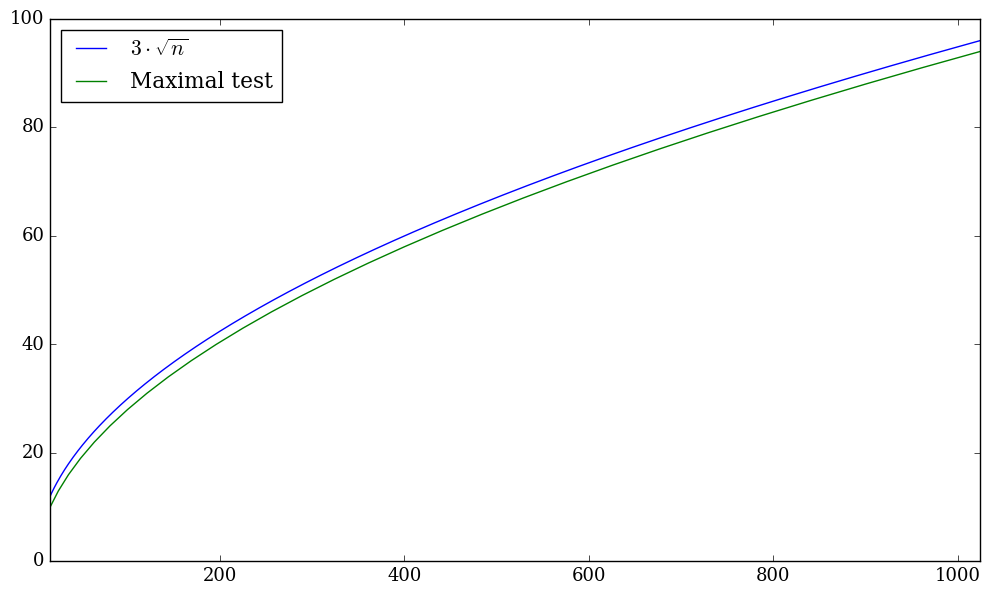

In [129]:
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0, 1024, 1000), 3 * np.linspace(0, 1024, 1000) ** 0.5, label=r'$3 \cdot \sqrt{n}$')
plt.plot(ns, nums, label='Maximal test')
plt.legend(loc='upper left')
plt.xlim(16, 1024)
plt.show()

### Случайные графы
Теперь проведем тестирование на случайных графах

In [109]:
def get_asymptotic_data(p=0.2):
    N = 303
    ns = range(1, N, 30)
    nums = []

    for n in ns:
        is_legal, num = test([n, n, n], p)
        nums.append(num)
    
    return ns, nums

In [110]:
ns = [0, 0, 0]
nums = [0, 0, 0]

ns[0], nums[0] = get_asymptotic_data(0.2)
ns[1], nums[1] = get_asymptotic_data(0.5)
ns[2], nums[2] = get_asymptotic_data(0.8)

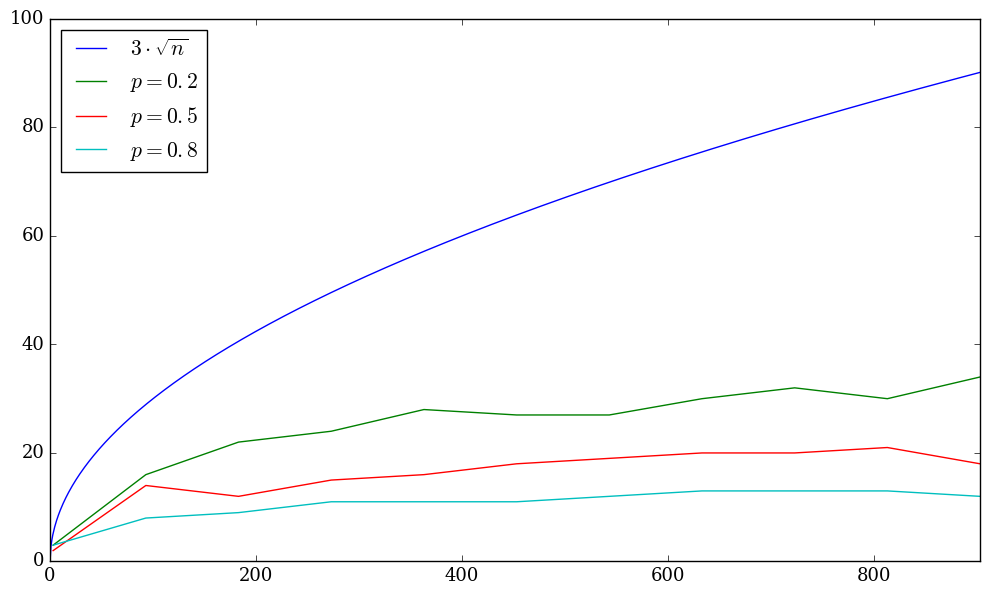

In [111]:
plt.figure(figsize=(12, 7))
N = max(ns[0])
plt.plot(np.linspace(0, N, 1000) * 3, 3 * np.sqrt(np.linspace(0, N, 1000) * 3), label=r'$3 \cdot \sqrt{n}$')
plt.plot(np.array(ns[0]) * 3, nums[0], label=r'$p = 0.2$')
plt.plot(np.array(ns[1]) * 3, nums[1], label=r'$p = 0.5$')
plt.plot(np.array(ns[2]) * 3, nums[2], label=r'$p = 0.8$')
plt.legend(loc='upper left')
plt.xlim(0, N * 3)
plt.show()

Асимптотика, очевидно, подтверждена.

Однако видим, что при увеличении $p$ приближение становится лучше. Посмотрим подробнее на график распределения количества цветов

## Распределение количества цветов по вероятностям

In [67]:
ns = [30, 30, 30]

num_colors = dict()
for p in np.linspace(0, 1, 11):
    num_colors[p] = 0

N = 10
for i in range(N):
    for p in np.linspace(0, 1, 11):
        is_legal, num = test(ns, p)
        assert is_legal
        num_colors[p] += num

ps = np.linspace(0, 1, 11)
num_colors = np.array(list(sorted(num_colors.items())))[:, 1] / N

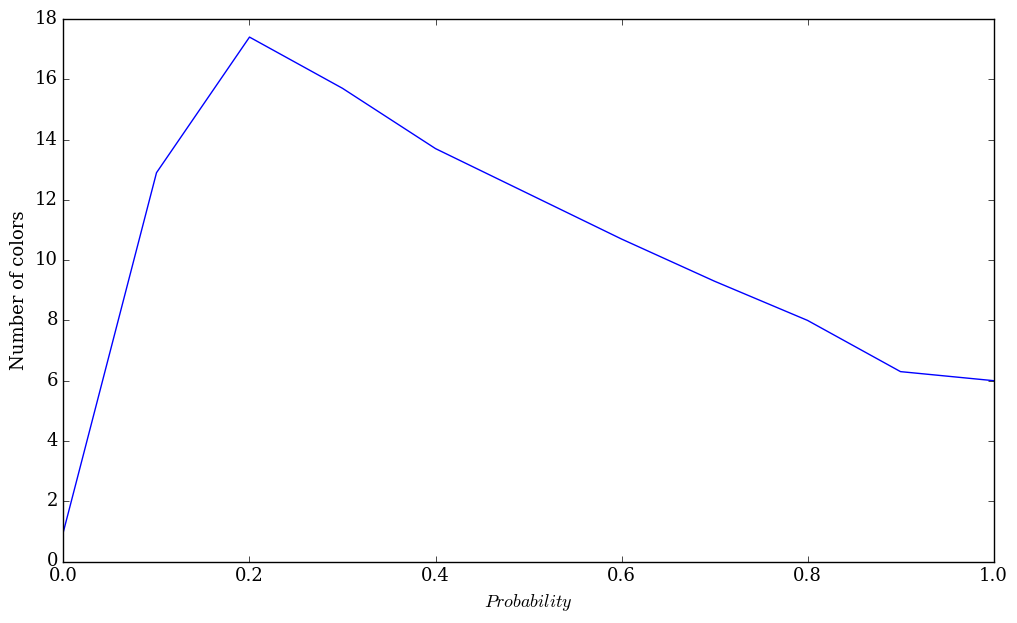

In [68]:
plt.figure(figsize=(12, 7))
plt.plot(ps, num_colors)
plt.xlabel(r'$Probability$')
plt.ylabel(r'Number of colors')
plt.show()

## Выводы
Видим, что есть выброс при $p = 0.2$. Это можно объяснить тем, что степени вершин уже маленькие, но граф еще достаточно сложный для жадного алгоритма. При малых $p$ будет просто жадный алгоритм, при больших как раз оправдано использование алгоритма Вигдерсона